# Imports, Installs and Loading Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
!pip install lime
!pip install shap
!pip install tensorflow --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 11.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=e17faa250e89a96f5c8c1eaa6f76bc7cc96f3bc4ea19c891917e0a59ef13fe22
  Stored in directory: /root/.cache/pip/wheels/e7/5d/0e/4b4fff9a47468fed5633211fb3b76d1db43fe806a17fb7486a
Successfully built lime
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 620.7/620.7 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 135.4 MB/s eta 0:00:00
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.19.0
    Uninstalling tensorboard-2.19.0:
      Successfully uninstalled tensorboard-2.19.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.19.0
    Uninstalling tensorflow-2.19.0:
      Successfully uninstalled tensorflow-2.19.0
ERROR: pip's dependency resolver does not currently take into account all the packages that ar

In [ ]:
from google.colab import files
import pandas as pd

# uploaded = files.upload()

hotels = pd.read_csv('/content/drive/MyDrive/ACL_Datasets/hotels.csv')
users = pd.read_csv('/content/drive/MyDrive/ACL_Datasets/users.csv')
reviews = pd.read_csv('/content/drive/MyDrive/ACL_Datasets/reviews.csv')

# uploaded = files.upload()
# hotels = pd.read_csv('hotels.csv')
# users = pd.read_csv('users.csv')
# reviews = pd.read_csv('reviews.csv')

# Dataset Cleaning

In this section, we perform an initial cleaning and inspection of the datasets to ensure that the data is ready for analysis. We focus on three main checks:

1. **Duplicated ID check** – Verify that unique identifiers (`hotel_id`, `user_id`, `review_id`) do not contain duplicates to avoid misleading aggregations or calculations.
2. **Missing / Null / Empty Values Check** – Detect any missing data, nulls, or empty strings that could affect analysis or model training.
3. **Unique Values** – Examine categorical columns to understand the diversity of values, which helps in detecting anomalies and planning for encoding or grouping.

## Duplicated ID check

This cell checks whether the unique identifier columns (`hotel_id`, `user_id`, `review_id`) contain any duplicate values.  

- **Why it matters:** Duplicate IDs can cause incorrect aggregation, counting, or merging results.  
- **How it works:** The `check_duplicates` function counts the number of duplicated entries in the specified ID column and prints a summary.  
- **Output:**  
  - If there are no duplicates, it confirms that the dataset is safe regarding unique identifiers.  
  - If duplicates exist, it reports how many and in which dataset, so we can decide whether to remove or investigate them.


In [ ]:
def check_duplicates(df, id_col, dataset_name):
    """Check if there are duplicate values in the ID column."""
    total = len(df)
    duplicates = df[id_col].duplicated().sum()
    print(f"{dataset_name}:")
    if duplicates == 0:
        print(f"\nNo duplicate {id_col} values found ({total:,} total records)\n")
    else:
        print(f"{duplicates:,} duplicate {id_col} values found out of {total:,} records\n")

# Run checks
check_duplicates(hotels, "hotel_id", "================ Hotels Dataset ================ ")
check_duplicates(users, "user_id", "================  Users Dataset ================ ")
check_duplicates(reviews, "review_id", "================  Reviews Dataset ================ ")


================ Hotels Dataset ================ :

No duplicate hotel_id values found (25 total records)

================  Users Dataset ================ :

No duplicate user_id values found (2,000 total records)

================  Reviews Dataset ================ :

No duplicate review_id values found (50,000 total records)



## Missing / Null / Empty Values Check


This cell inspects each dataset for missing or empty values, including `NaN`, `None`, or blank strings.  

- **Why it matters:** Missing or empty data can affect analysis, summary statistics, or machine learning models.  
- **How it works:** The `check_missing` function calculates:  
  - `NaN_or_None`: counts missing values (`NaN` or `None`)  
  - `Empty_or_Whitespace`: counts empty strings or strings containing only spaces  
  - `Total_Missing`: sum of both for each column  
- **Output:**  
  - If no missing data is found, it prints a confirmation.  
  - If missing values exist, it shows a table with columns sorted by the total missing values to prioritize cleaning.


In [ ]:
def check_missing(df, dataset_name):
    """Check for NaN, None, or empty-string values in the dataset."""
    print(f"\n===================== {dataset_name} =====================")

    null_counts = df.isna().sum()
    empty_counts = (df.map(lambda x: isinstance(x, str) and x.strip() == "")).sum()

    missing_summary = pd.DataFrame({
        "NaN_or_None": null_counts,
        "Empty_or_Whitespace": empty_counts,
        "Total_Missing": null_counts + empty_counts
    })

    missing_summary = missing_summary[missing_summary["Total_Missing"] > 0]

    if missing_summary.empty:
        print("\nNo missing or empty values found in this dataset.")
    else:
        display(missing_summary.sort_values("Total_Missing", ascending=False))


# Run checks
check_missing(hotels, "Hotels Dataset")
check_missing(users, "Users Dataset")
check_missing(reviews, "Reviews Dataset")



===================== Hotels Dataset =====================

No missing or empty values found in this dataset.

===================== Users Dataset =====================

No missing or empty values found in this dataset.

===================== Reviews Dataset =====================

No missing or empty values found in this dataset.


## Unique values

This cell examines categorical columns to understand the diversity of values in each dataset.  

- **Why it matters:** Knowing the number of unique categories helps detect anomalies, plan encoding, and understand the data distribution.  
- **How it works:** The `show_unique_values` function iterates over the specified categorical columns and prints:  
  - The number of unique values in the column  
  - A sample of all unique values  
- **Output:**  
  - Gives a quick overview of the diversity in each categorical column.  
  - Helps spot unusual or unexpected values that might need standardization or grouping.


In [ ]:
def show_unique_values(df, categorical_cols, dataset_name):
    """Display number of unique values and sample unique values for given columns."""
    print(f"\n========================== {dataset_name} ==========================")
    for col in categorical_cols:
        n_unique = df[col].nunique(dropna=True)
        unique_vals = df[col].dropna().unique()
        print(f"\n ---------------- {col}: {n_unique} unique values ---------------- ")
        print(f"\n{unique_vals}")

# Define the categorical columns
hotels_cat = ["hotel_name", "city", "country", "star_rating"]
users_cat = ["user_gender", "country", "age_group", "traveller_type"]

# Show unique values
show_unique_values(hotels, hotels_cat, "Hotels Dataset")
show_unique_values(users, users_cat, "Users Dataset")



========================== Hotels Dataset ==========================

 ---------------- hotel_name: 25 unique values ---------------- 

['The Azure Tower' 'The Royal Compass' "L'Étoile Palace" 'Kyo-to Grand'
 'The Golden Oasis' 'Marina Bay Zenith' 'Sydney Harbour Grand'
 'Copacabana Lux' 'Berlin Mitte Elite' 'The Maple Grove' 'The Bund Palace'
 'Aztec Heights' 'The Gateway Royale' 'Colosseum Gardens'
 'Table Mountain View' 'Han River Oasis' 'Kremlin Suites' 'Nile Grandeur'
 "Gaudi's Retreat" 'The Orchid Palace' 'The Bosphorus Inn'
 'Canal House Grand' 'Tango Boutique' 'The Savannah House'
 'The Kiwi Grand']

 ---------------- city: 25 unique values ---------------- 

['New York' 'London' 'Paris' 'Tokyo' 'Dubai' 'Singapore' 'Sydney'
 'Rio de Janeiro' 'Berlin' 'Toronto' 'Shanghai' 'Mexico City' 'Mumbai'
 'Rome' 'Cape Town' 'Seoul' 'Moscow' 'Cairo' 'Barcelona' 'Bangkok'
 'Istanbul' 'Amsterdam' 'Buenos Aires' 'Lagos' 'Wellington']

 ---------------- country: 25 unique values -------------

# Exploratory Data Analysis (EDA)

In this section, we explore the datasets to understand their structure, distribution, and relationships. The goal is to gain insights, identify patterns, and prepare the data for further analysis or modeling. We focus on three main aspects:  

1. **General Overview** – Examine the dataset’s shape, column types, and basic information.  
2. **Statistics** – Calculate numeric summaries and categorical counts to understand the data distribution.  
3. **Visualizations** – Create plots such as histograms, boxplots, bar charts, and correlation heatmaps to visually analyze the data.


## General OverView

This section provides a quick summary of the datasets to understand their structure and contents. It covers:  

- **Dataset Shape:** Number of rows and columns in each dataset  
- **Dataset Columns:** Names of all columns available  
- **Data Types:** Type of data stored in each column (numeric, categorical, etc.)  
- **Dataset Sample:** A small snapshot of the data to see actual values  

**Why it matters:** Understanding the size, structure, and type of the data early helps identify potential issues, guides further cleaning, and informs analysis or modeling decisions.  

**How it works:** The code displays shapes, column names, data types, and sample rows for Hotels, Users, and Reviews datasets, providing a concise overview for a first look at the data.


### Dataset Shape

This cell checks the **number of rows and columns** in each dataset.  

- **Why it matters:** Knowing the dataset size helps understand the scale of data we are working with and plan analysis or visualization accordingly.  
- **Expected output:**  
  - A simple printout showing the shape of each dataset in the format `(rows, columns)`.  
  - Example: `Hotels: (1000, 12)` means 1000 rows and 12 columns.


In [ ]:
# Quick checks
print("Loaded shapes:")
print("Hotels:", hotels.shape)
print("Users:", users.shape)
print("Reviews:", reviews.shape)

Loaded shapes:
Hotels: (25, 13)
Users: (2000, 6)
Reviews: (50000, 12)


### Dataset Columns

This cell lists the **names of all columns** in each dataset.  

- **Why it matters:** Helps understand what information is available in each dataset and guides the selection of columns for analysis or modeling.  
- **Expected output:**  
  - A table showing all column names for Hotels, Users, and Reviews.  
  - Allows you to quickly identify which columns are categorical, numeric, or identifiers.


In [ ]:
# Show column names
display(pd.DataFrame({'Hotels Columns': hotels.columns}).T)
display(pd.DataFrame({'Users Columns': users.columns}).T)
display(pd.DataFrame({'Reviews Columns': reviews.columns}).T)


,0,1,2,3,4,5,6,7,8,9,10,11,12
Hotels Columns,hotel_id,hotel_name,city,country,star_rating,lat,lon,cleanliness_base,comfort_base,facilities_base,location_base,staff_base,value_for_money_base


,0,1,2,3,4,5
Users Columns,user_id,user_gender,country,age_group,traveller_type,join_date


,0,1,2,3,4,5,6,7,8,9,10,11
Reviews Columns,review_id,user_id,hotel_id,review_date,score_overall,score_cleanliness,score_comfort,score_facilities,score_location,score_staff,score_value_for_money,review_text


### Data Types

This cell shows the **data type of each column** in a clean, sorted table.  

- **Why it matters:**  
  - Ensures numeric columns are correctly recognized as numbers, and categorical columns as objects.  
  - Detects columns that may need type conversion (e.g., dates stored as strings).  
- **How it works:**  
  - The `show_dtypes` function creates a DataFrame with column names and their types, sorts by type, and displays it neatly.  
- **Expected output:**  
  - A table listing all columns with their respective data types (`int64`, `float64`, `object`, etc.) for each dataset.


In [ ]:
def show_dtypes(df, name):
    """Display column datatypes in a clean, sorted DataFrame."""
    summary = pd.DataFrame({
        'column': df.columns,
        'dtype': df.dtypes.astype(str)
    }).sort_values(by='dtype').reset_index(drop=True)

    display(summary.style.set_caption(f"======================= {name} — Data Types =======================\n")
                     .hide(axis='index'))  # hides the default index

# Show summaries for all three datasets
show_dtypes(hotels, "Hotels Dataset")
show_dtypes(users, "Users Dataset")
show_dtypes(reviews, "Reviews Dataset")


column,dtype
lat,float64
lon,float64
cleanliness_base,float64
comfort_base,float64
facilities_base,float64
location_base,float64
staff_base,float64
value_for_money_base,float64
hotel_id,int64
star_rating,int64


column,dtype
user_id,int64
user_gender,object
country,object
age_group,object
traveller_type,object
join_date,object


column,dtype
score_overall,float64
score_cleanliness,float64
score_comfort,float64
score_facilities,float64
score_location,float64
score_staff,float64
score_value_for_money,float64
review_id,int64
user_id,int64
hotel_id,int64


### Dataset sample

This cell shows **a small sample of the data** from each dataset to get a quick look at the actual content.  

- **Why it matters:**  
  - Helps verify that the data looks as expected.  
  - Allows spotting anomalies or formatting issues (e.g., unexpected characters or missing values).  
- **Expected output:**  
  - The first few rows of Hotels, Users, and Reviews datasets displayed in a readable table format.  
  - Example: hotel names, user age groups, review scores, etc.


In [ ]:
# Show 1 random instance from each (deterministic sample)
print("One sample from each dataset:")
sample1 = hotels.head()
sample2 = users.head()
sample3 = reviews.head()

display(sample1)
display(sample2)
display(sample3)

One sample from each dataset:


,hotel_id,hotel_name,city,country,star_rating,lat,lon,cleanliness_base,comfort_base,facilities_base,location_base,staff_base,value_for_money_base
0,1,The Azure Tower,New York,United States,5,40.7580,-73.9855,9.1,8.8,8.9,9.5,8.6,8.0
1,2,The Royal Compass,London,United Kingdom,5,51.5072,-0.1276,9.0,9.2,8.8,9.4,9.0,7.9
2,3,L'Étoile Palace,Paris,France,5,48.8566,2.3522,8.8,9.4,8.7,9.6,9.3,8.1
3,4,Kyo-to Grand,Tokyo,Japan,5,35.6895,139.6917,9.6,9.0,9.3,8.5,9.5,8.2
4,5,The Golden Oasis,Dubai,United Arab Emirates,5,25.2769,55.2962,9.3,9.5,9.6,8.9,9.4,8.5


,user_id,user_gender,country,age_group,traveller_type,join_date
0,1,Female,United Kingdom,35-44,Solo,2024-09-29
1,2,Male,United Kingdom,25-34,Solo,2023-11-29
2,3,Female,Mexico,25-34,Family,2022-04-03
3,4,Male,India,35-44,Family,2023-12-02
4,5,Other,Japan,25-34,Solo,2021-12-18


,review_id,user_id,hotel_id,review_date,score_overall,score_cleanliness,score_comfort,score_facilities,score_location,score_staff,score_value_for_money,review_text
0,1,1600,1,2022-10-07,8.7,8.6,8.7,8.5,9.0,8.8,8.7,Practice reduce young our because machine. Rec...
1,2,432,4,2020-03-24,9.1,10.0,9.1,9.0,8.6,9.4,8.6,Test cover traditional black. Process tell Mr ...
2,3,186,18,2023-12-18,8.8,9.7,8.8,8.3,8.7,8.1,8.6,Friend million student social study yeah. Grow...
3,4,1403,19,2022-06-22,8.9,9.0,8.8,8.5,9.6,9.1,8.3,Huge girl already remain truth behind card. Ap...
4,5,1723,17,2022-07-02,9.1,8.9,9.5,9.3,8.3,9.4,8.9,Cover feeling call community serve television ...


## Statistics

This cell calculates summary statistics for numeric and categorical columns:  

- **Numeric columns:** mean, median, min, max, and standard deviation  
- **Categorical columns:** number of unique values  

- **Why it matters:**  
  - Numeric summaries provide insight into the central tendency, spread, and potential outliers.  
  - Categorical summaries help understand diversity and detect anomalies or rare categories.  
- **How it works:**  
  - Numeric columns are aggregated using pandas functions (`mean`, `median`, `min`, `max`, `std`).  
  - Categorical columns are counted to show the number of unique values and sample categories.


### Mean, median, min, max, and standard deviation of numeric columns.

This cell calculates basic statistics for numeric columns in each dataset, including mean, median, minimum, maximum, and standard deviation.  

- **Why it matters:**  
  - Helps understand the central tendency and spread of numeric data.  
  - Detects potential outliers or unexpected values.  
- **How it works:**  
  - The `numeric_summary` function selects numeric columns, excluding any ID columns.  
  - It computes mean, median, min, max, and standard deviation for each numeric column and displays the results in a clean table.  
- **Expected output:**  
  - A table for each dataset showing the numeric summary of relevant columns (e.g., review scores, hotel ratings).


In [ ]:
def numeric_summary(df, dataset_name, id_cols=None):
    """Show mean, median, min, max, and std for numeric columns (excluding ID columns)."""
    print(f"\n===================== {dataset_name} =====================")

    # Exclude ID columns if provided
    if id_cols:
        df = df.drop(columns=[col for col in id_cols if col in df.columns])

    # Select only numeric columns
    num_df = df.select_dtypes(include=["number"])

    # Skip if no numeric columns left
    if num_df.empty:
        print("No numeric columns found.")
        return

    # Compute summary
    summary = pd.DataFrame({
        "mean": num_df.mean(),
        "median": num_df.median(),
        "min": num_df.min(),
        "max": num_df.max(),
        "std": num_df.std()
    }).round(2)

    display(summary.style.set_caption(f"{dataset_name} — Numeric Summary").format(precision=2))

# Run for all datasets
numeric_summary(hotels, "Hotels Dataset", id_cols=["hotel_id", "lat", "lon"])
numeric_summary(users, "Users Dataset", id_cols=["user_id"])
numeric_summary(reviews, "Reviews Dataset", id_cols=["review_id", "user_id", "hotel_id"])



===================== Hotels Dataset =====================


,mean,median,min,max,std
star_rating,5.00,5.00,5.00,5.00,0.00
cleanliness_base,9.09,9.10,8.70,9.60,0.23
comfort_base,9.06,9.10,8.60,9.50,0.24
facilities_base,8.92,8.90,8.50,9.60,0.29
location_base,9.27,9.30,8.50,9.80,0.36
staff_base,9.02,9.00,8.60,9.50,0.24
value_for_money_base,8.51,8.50,7.90,8.90,0.27



===================== Users Dataset =====================
No numeric columns found.

===================== Reviews Dataset =====================


,mean,median,min,max,std
score_overall,8.94,8.90,8.20,9.60,0.18
score_cleanliness,9.05,9.10,7.70,10.00,0.50
score_comfort,9.02,9.00,7.90,10.00,0.42
score_facilities,8.74,8.70,7.60,10.00,0.50
score_location,9.18,9.20,7.90,10.00,0.42
score_staff,8.97,9.00,7.90,10.00,0.40
score_value_for_money,8.43,8.50,6.80,9.70,0.53


### Count of categories in categorical columns.

This cell counts the number of unique values for each categorical column and displays their frequency distribution.  

- **Why it matters:**  
  - Helps understand the diversity of categorical data.  
  - Identifies common or rare categories, which is useful for grouping or encoding later.  
- **How it works:**  
  - The `count_categories` function iterates over each categorical column, calculates the number of unique categories, and shows the frequency of each category.  
- **Expected output:**  
  - For each categorical column, a table showing the count of each unique value (e.g., number of hotels per city, users per age group).


In [ ]:
def count_categories(df, categorical_cols, dataset_name):
    """Show count of categories for each categorical column."""
    print(f"\n===================== {dataset_name} =====================")
    for col in categorical_cols:
        print(f"\n🔹 {col} — {df[col].nunique()} unique categories")
        display(df[col].value_counts(dropna=False).to_frame(name='count'))

# Define categorical columns
hotels_cat = ["hotel_name", "city", "country", "star_rating"]
users_cat = ["user_gender", "country", "age_group", "traveller_type"]
reviews_cat = []  # None in reviews

# Run for all datasets
count_categories(hotels, hotels_cat, "Hotels Dataset")
count_categories(users, users_cat, "Users Dataset")
count_categories(reviews, reviews_cat, "Reviews Dataset")



===================== Hotels Dataset =====================

🔹 hotel_name — 25 unique categories


,count
hotel_name,
The Azure Tower,1
The Royal Compass,1
L'Étoile Palace,1
Kyo-to Grand,1
The Golden Oasis,1
Marina Bay Zenith,1
Sydney Harbour Grand,1
Copacabana Lux,1
Berlin Mitte Elite,1



🔹 city — 25 unique categories


,count
city,
New York,1
London,1
Paris,1
Tokyo,1
Dubai,1
Singapore,1
Sydney,1
Rio de Janeiro,1
Berlin,1



🔹 country — 25 unique categories


,count
country,
United States,1
United Kingdom,1
France,1
Japan,1
United Arab Emirates,1
Singapore,1
Australia,1
Brazil,1
Germany,1



🔹 star_rating — 1 unique categories


,count
star_rating,
5,25



===================== Users Dataset =====================

🔹 user_gender — 3 unique categories


,count
user_gender,
Male,942
Female,864
Other,194



🔹 country — 25 unique categories


,count
country,
United States,280
United Kingdom,231
Germany,156
China,155
France,134
Japan,105
Brazil,98
Canada,95
Australia,69



🔹 age_group — 5 unique categories


,count
age_group,
25-34,653
35-44,611
45-54,317
18-24,218
55+,201



🔹 traveller_type — 4 unique categories


,count
traveller_type,
Couple,694
Family,478
Solo,420
Business,408



===================== Reviews Dataset =====================


### Country Group Creation and Reviews per Group

This cell creates a new column `country_group` in the hotels dataset, merges all datasets, and calculates the number of reviews per country group.  

- **Why it matters:**  
  - Grouping countries into regions simplifies analysis at a higher level.  
  - Shows which regions have the most reviews, useful for understanding dataset coverage.  
- **How it works:**  
  - Maps the original `country` column in hotels to broader regions (`country_group`).  
  - Drops the original country column to avoid confusion during merging.  
  - Merges Hotels, Users, and Reviews datasets.  
  - Counts the number of reviews per country group and displays the result.  
- **Expected output:**  
  - A table showing `country_group` and `review_count`, e.g., `North_America — 1500 reviews`.


In [ ]:
# Step 1: Create the country_group column in the hotels dataset
country_group_mapping = {
    "United States": "North_America",
    "Canada": "North_America",
    "Germany": "Western_Europe",
    "France": "Western_Europe",
    "United Kingdom": "Western_Europe",
    "Netherlands": "Western_Europe",
    "Spain": "Western_Europe",
    "Italy": "Western_Europe",
    "Russia": "Eastern_Europe",
    "China": "East_Asia",
    "Japan": "East_Asia",
    "South Korea": "East_Asia",
    "Thailand": "Southeast_Asia",
    "Singapore": "Southeast_Asia",
    "United Arab Emirates": "Middle_East",
    "Turkey": "Middle_East",
    "Egypt": "Africa",
    "Nigeria": "Africa",
    "South Africa": "Africa",
    "Australia": "Oceania",
    "New Zealand": "Oceania",
    "Brazil": "South_America",
    "Argentina": "South_America",
    "India": "South_Asia",
    "Mexico": "North_America_Mexico"
}

# ✅ Add the mapping to hotels
hotels["country_group"] = hotels["country"].map(country_group_mapping)

# Step 2: Drop other 'country' columns before merging (optional, for clarity)
# Keep only country_group instead of original country
hotels_cleaned = hotels.drop(columns=["country"])

# Step 3: Merge datasets
merged_df = (
    reviews
    .merge(hotels_cleaned, on="hotel_id", how="left")
    .merge(users, on="user_id", how="left", suffixes=("", "_user"))
)

# Step 4: Calculate number of reviews per country group
reviews_by_group = (
    merged_df["country_group"]
    .value_counts()
    .reset_index()
    .rename(columns={"index": "country_group", "country_group": "review_count"})
)

display(reviews_by_group)


,review_count,count
0,Western_Europe,11876
1,Africa,6132
2,East_Asia,6082
3,Southeast_Asia,4070
4,Oceania,4014
5,Middle_East,3983
6,North_America,3962
7,South_America,3918
8,North_America_Mexico,2004
9,South_Asia,1989


## Visualizations

This section generates graphical representations of numeric and categorical columns to highlight patterns, distributions, outliers, and correlations.  

- **Histograms:** reveal how numeric values are distributed.  
- **Boxplots:** show spread and detect outliers in numeric columns.  
- **Bar charts:** show counts of categories in categorical columns.  
- **Correlation heatmaps:** reveal linear relationships between numeric columns.  

**Why it matters:**  
- Makes trends, distributions, and correlations more apparent than raw tables.  
- Helps detect anomalies, patterns, or unexpected behavior in the data.  

**How it works:**  
- Uses Matplotlib for histograms and figure layouts.  
- Uses Seaborn for boxplots, bar charts, and heatmaps with styling for clarity.


### Histograms → show value spread (distributions) of numeric columns

This cell plots histograms for numeric columns to show the spread of values in the datasets.  

- **Why it matters:**  
  - Helps understand the distribution of numeric data (e.g., whether ratings are skewed, uniform, or concentrated around certain values).  
  - Identifies potential outliers or unusual clusters.  
- **How it works:**  
  - The `plot_histograms` function uses matplotlib to plot histograms for each numeric column.  
  - Each histogram shows the frequency of values along the y-axis and value ranges along the x-axis.  
- **Expected output:**  
  - One figure per dataset with histograms for all numeric columns (e.g., hotel scores or review scores).  


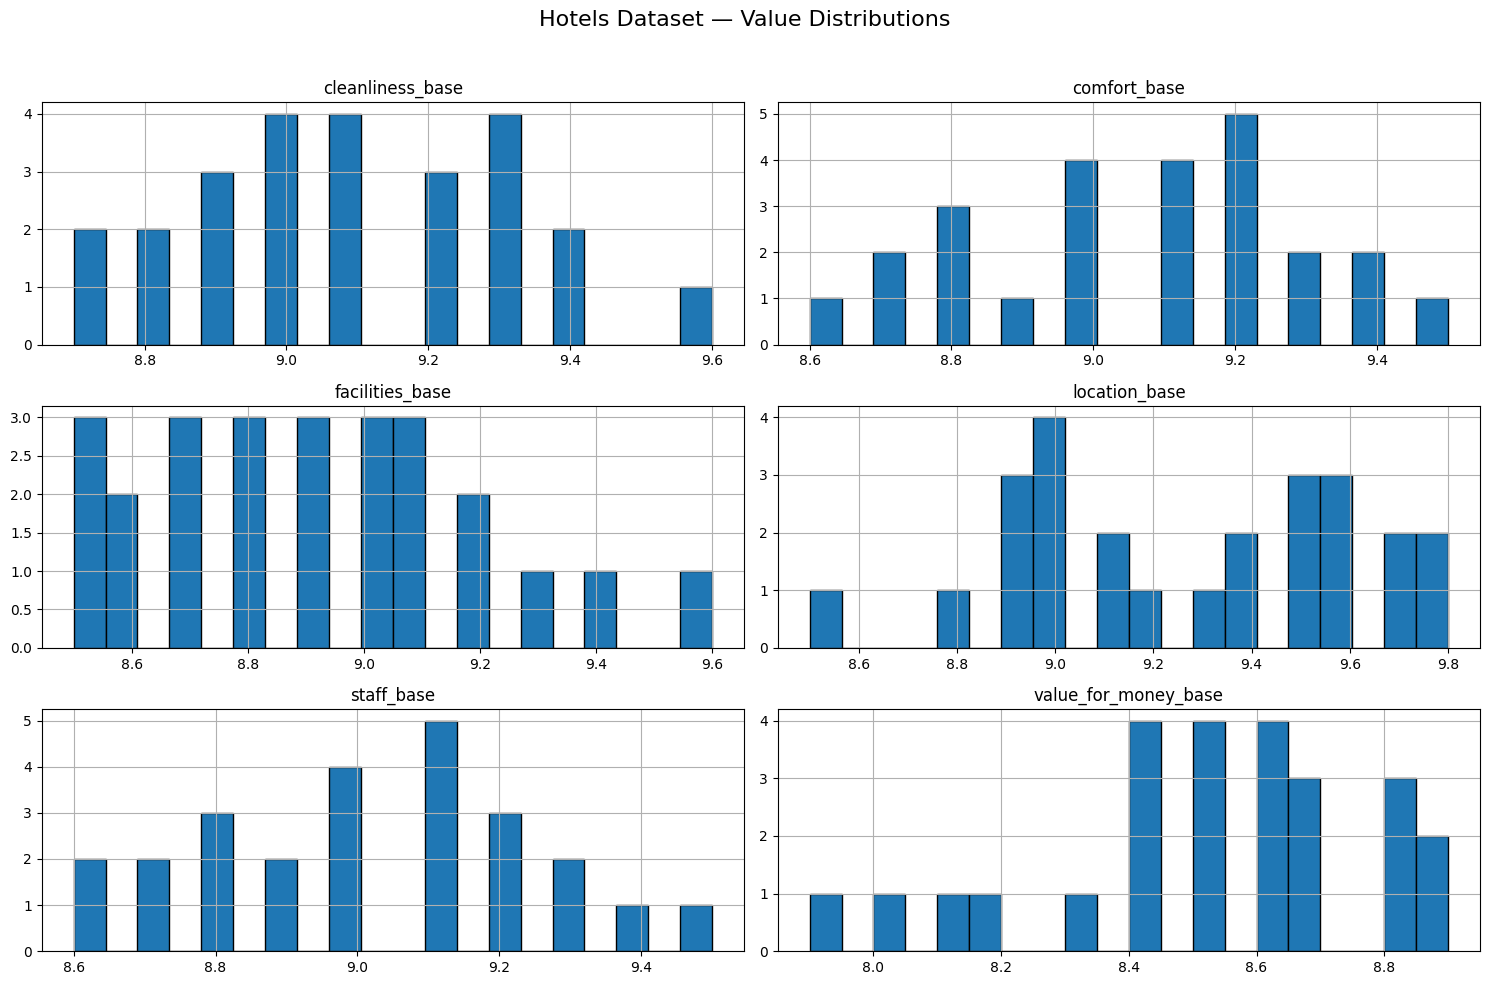

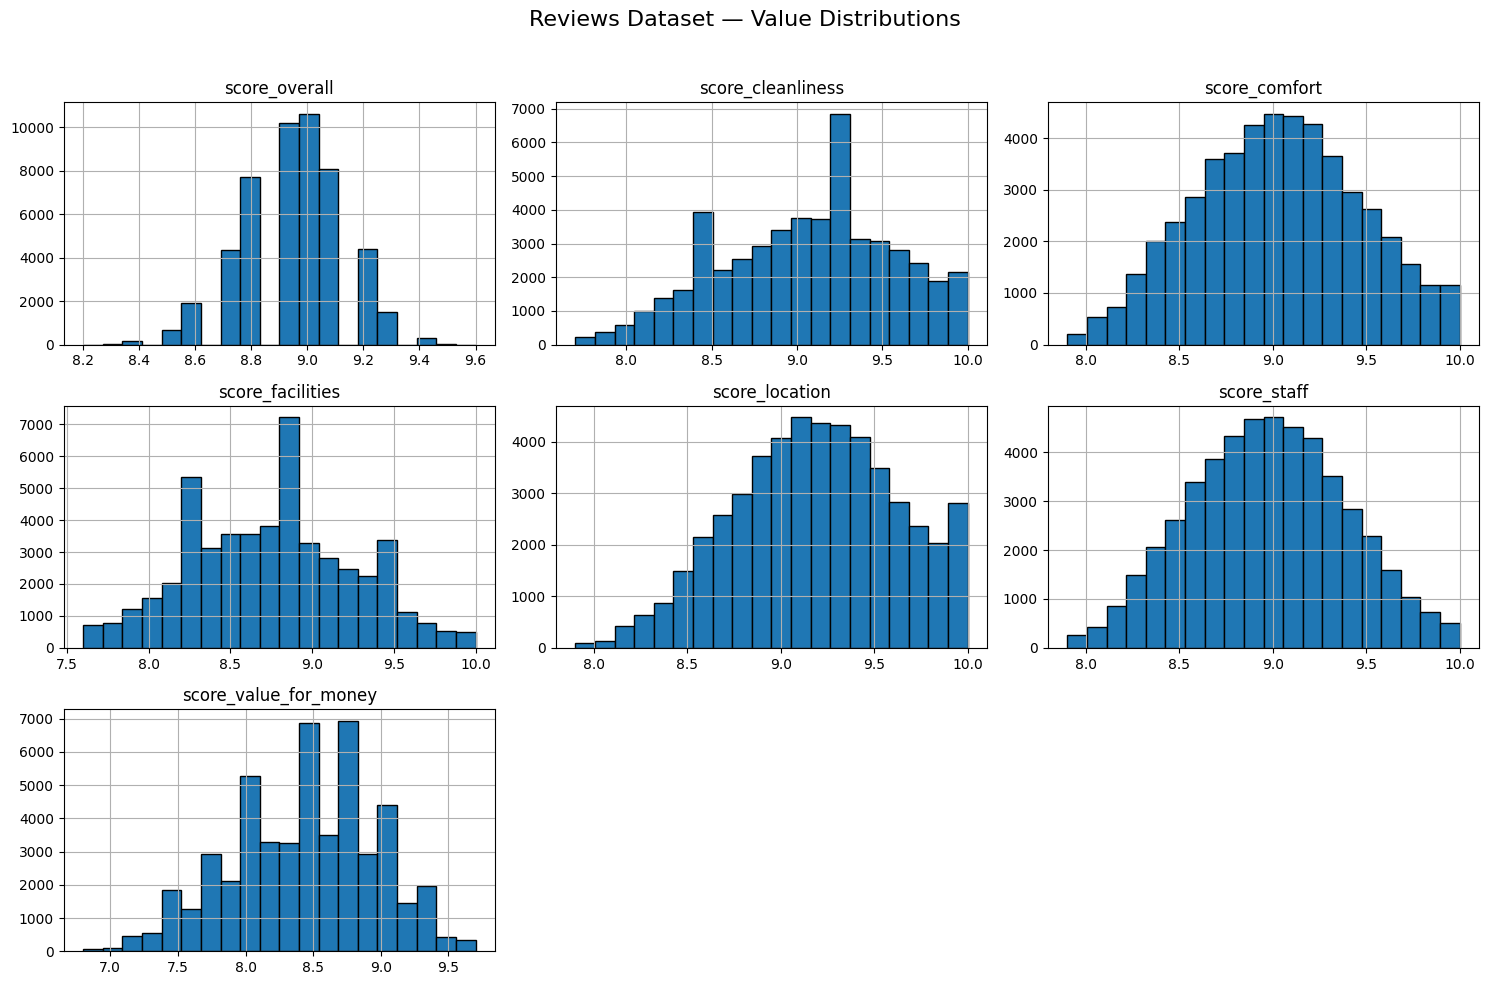

In [ ]:
import matplotlib.pyplot as plt

def plot_histograms(df, columns, dataset_name):
    """Plot histograms for given numeric columns."""
    # print(f"\n===================== {dataset_name} — Histograms =====================")
    df[columns].hist(figsize=(15, 10), bins=20, edgecolor='black')
    plt.suptitle(f"{dataset_name} — Value Distributions", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# Plot for Hotels and Reviews
plot_histograms(hotels,
                ['cleanliness_base', 'comfort_base',
                 'facilities_base', 'location_base', 'staff_base', 'value_for_money_base'],
                "Hotels Dataset")

plot_histograms(reviews,
                ['score_overall', 'score_cleanliness', 'score_comfort',
                 'score_facilities', 'score_location', 'score_staff', 'score_value_for_money'],
                "Reviews Dataset")


### Boxplots → show spread + outliers

This cell generates vertical boxplots for numeric columns to visualize the spread and detect outliers.  

- **Why it matters:**  
  - Boxplots highlight median, quartiles, and extreme values.  
  - Useful for spotting outliers that could influence analysis.  
- **How it works:**  
  - The `plot_boxplots` function uses seaborn to create vertical boxplots.  
  - Each subplot corresponds to one numeric column, displaying the median, interquartile range, and outliers.  
- **Expected output:**  
  - A grid of vertical boxplots for each numeric column in Hotels and Reviews datasets.


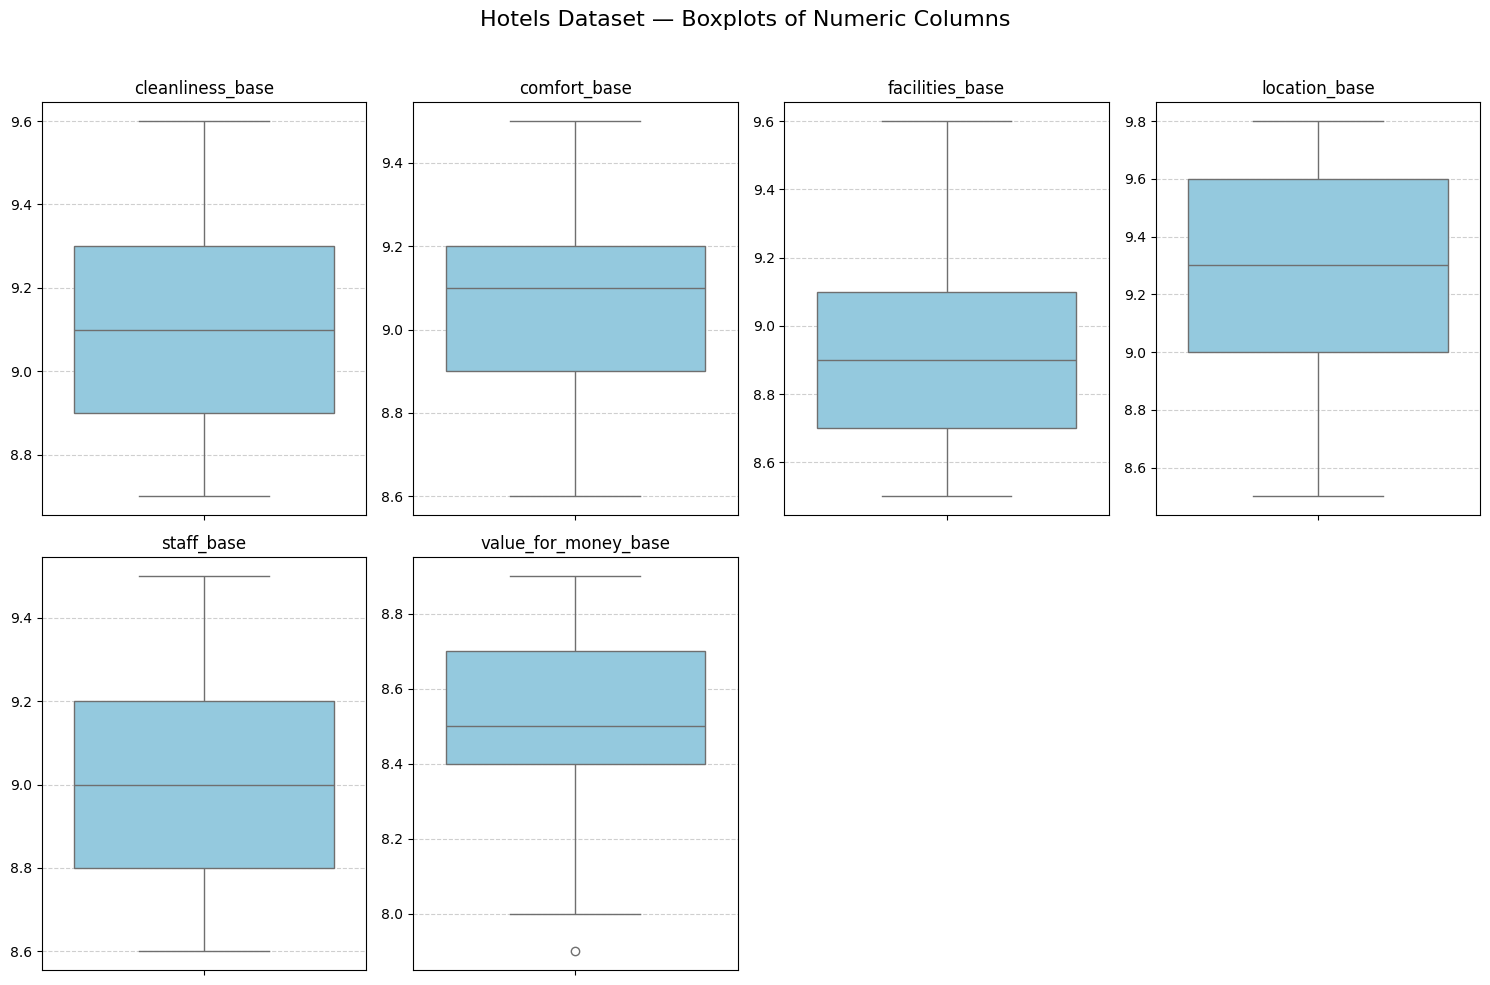

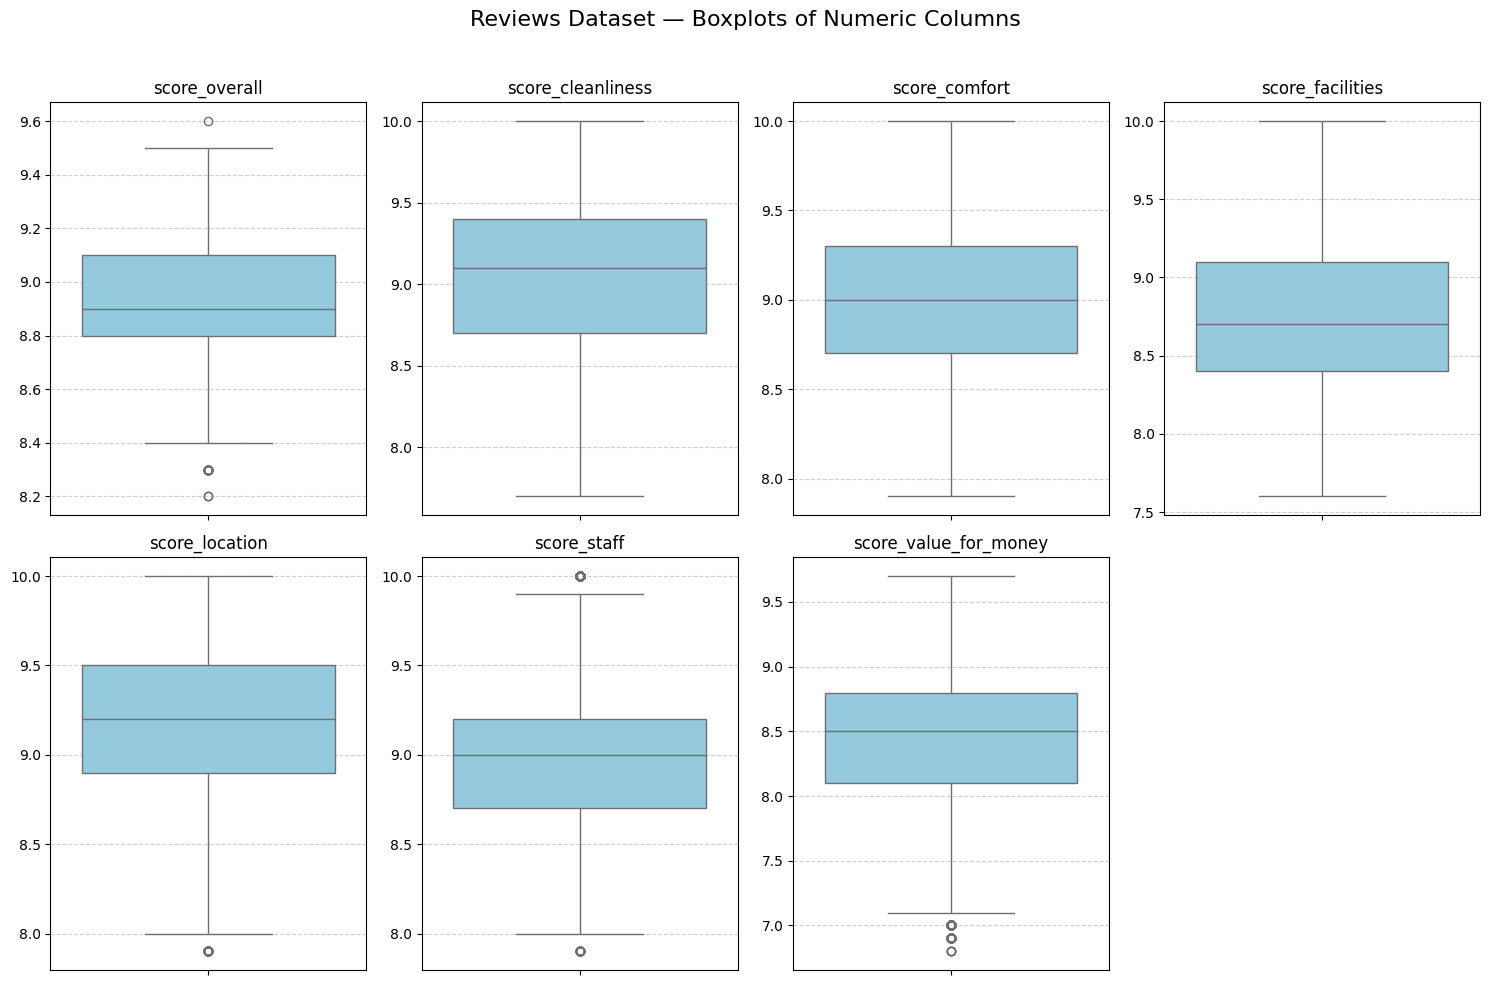

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_boxplots(df, columns, dataset_name):
    """Plot vertical boxplots for given numeric columns."""
    # print(f"\n===================== {dataset_name} — Boxplots =====================")

    n_cols = 4  # number of plots per row
    n_rows = (len(columns) + n_cols - 1) // n_cols

    plt.figure(figsize=(15, 5 * n_rows))

    for i, col in enumerate(columns, 1):
        plt.subplot(n_rows, n_cols, i)
        sns.boxplot(y=df[col], color='skyblue')  # <-- vertical boxplot
        plt.title(col, fontsize=12)
        plt.ylabel("")  # hide repeated label for cleanliness
        plt.grid(axis='y', linestyle='--', alpha=0.6)

    plt.suptitle(f"{dataset_name} — Boxplots of Numeric Columns", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


# ==================== Run for Hotels and Reviews ====================

# 🏨 Hotels Dataset
plot_boxplots(
    hotels,
    ['cleanliness_base', 'comfort_base', 'facilities_base', 'location_base',
     'staff_base', 'value_for_money_base'],
    "Hotels Dataset"
)

# 📝 Reviews Dataset
plot_boxplots(
    reviews,
    ['score_overall', 'score_cleanliness', 'score_comfort',
     'score_facilities', 'score_location', 'score_staff', 'score_value_for_money'],
    "Reviews Dataset"
)


### Bar charts → show categorical distributions (like gender, traveller type, etc.)

This cell plots bar charts for categorical columns to show counts of each category.  

- **Why it matters:**  
  - Helps understand the distribution of categorical data, such as gender, traveller type, or age group.  
  - Reveals imbalances or rare categories that may need attention.  
- **How it works:**  
  - The `plot_bar_charts` function uses seaborn to plot vertical bar charts.  
  - Subplots are displayed side-by-side for easy comparison.  
- **Expected output:**  
  - One figure for Users dataset with vertical bar charts for `user_gender`, `age_group`, and `traveller_type`.


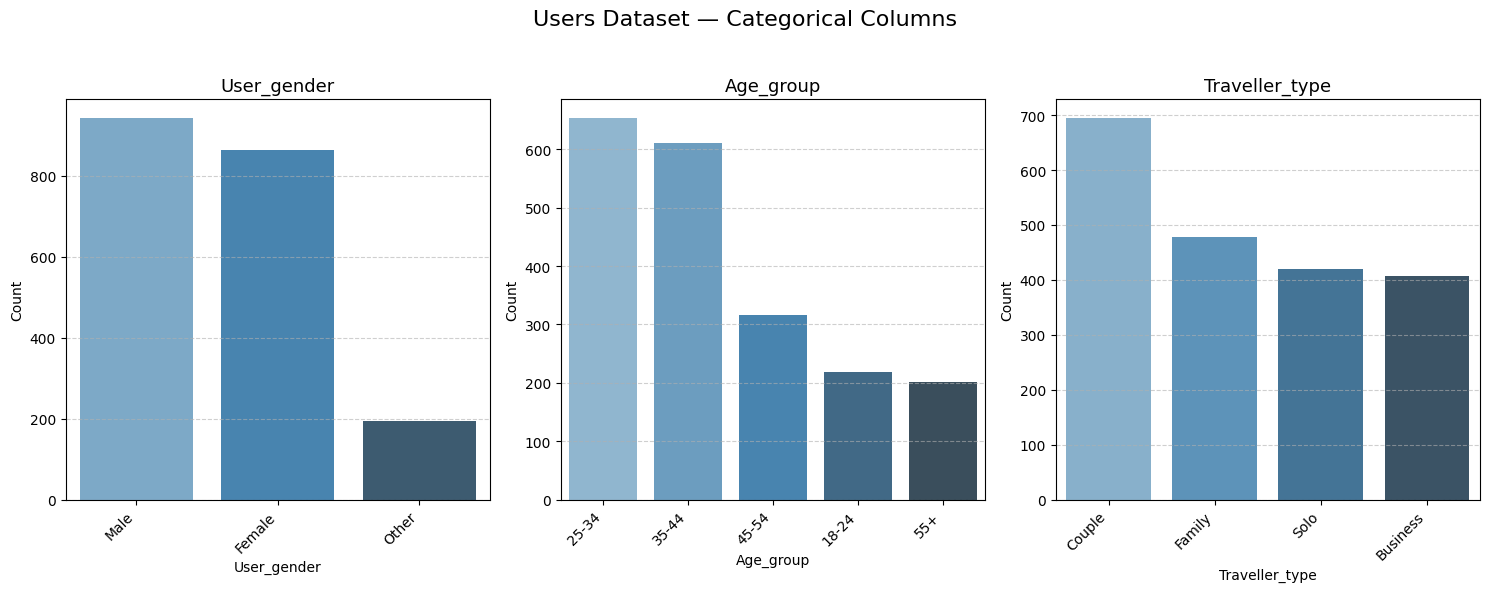

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_bar_charts(df, categorical_cols, dataset_name):
    """Plot vertical bar charts for all categorical columns side-by-side in one figure."""

    # Create subplots — one per categorical column
    n_cols = len(categorical_cols)
    plt.figure(figsize=(5 * n_cols, 6))  # width scales with number of charts

    for i, col in enumerate(categorical_cols, 1):
        if col not in df.columns:
            print(f"⚠️ Column '{col}' not found in {dataset_name}. Skipping...")
            continue

        counts = df[col].value_counts()

        plt.subplot(1, n_cols, i)
        sns.barplot(
            x=counts.index,
            y=counts.values,
            hue=counts.index,
            palette="Blues_d",
            legend=False
        )
        plt.title(col.capitalize(), fontsize=13)
        plt.xlabel(col.capitalize())
        plt.ylabel("Count")
        plt.xticks(rotation=45, ha='right')
        plt.grid(axis="y", linestyle="--", alpha=0.6)

    plt.suptitle(f"{dataset_name} — Categorical Columns", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


# ==================== Run for Users ====================

# 👤 Users Dataset
plot_bar_charts(users, ["user_gender", "age_group", "traveller_type"], "Users Dataset")


### Correlations heatmap → show relationships between numeric columns

This cell generates side-by-side correlation heatmaps for numeric columns in Hotels and Reviews datasets.  

- **Why it matters:**  
  - Shows relationships between numeric features (e.g., whether high cleanliness scores are correlated with high comfort scores).  
  - Helps identify redundant variables or potential multicollinearity.  
- **How it works:**  
  - `plot_two_heatmaps` calculates pairwise correlations and uses seaborn to display them in a color-coded matrix.  
  - Each heatmap shows correlation values between -1 and 1.  
- **Expected output:**  
  - Two heatmaps displayed side-by-side, one for Hotels and one for Reviews, showing correlations between numeric columns.


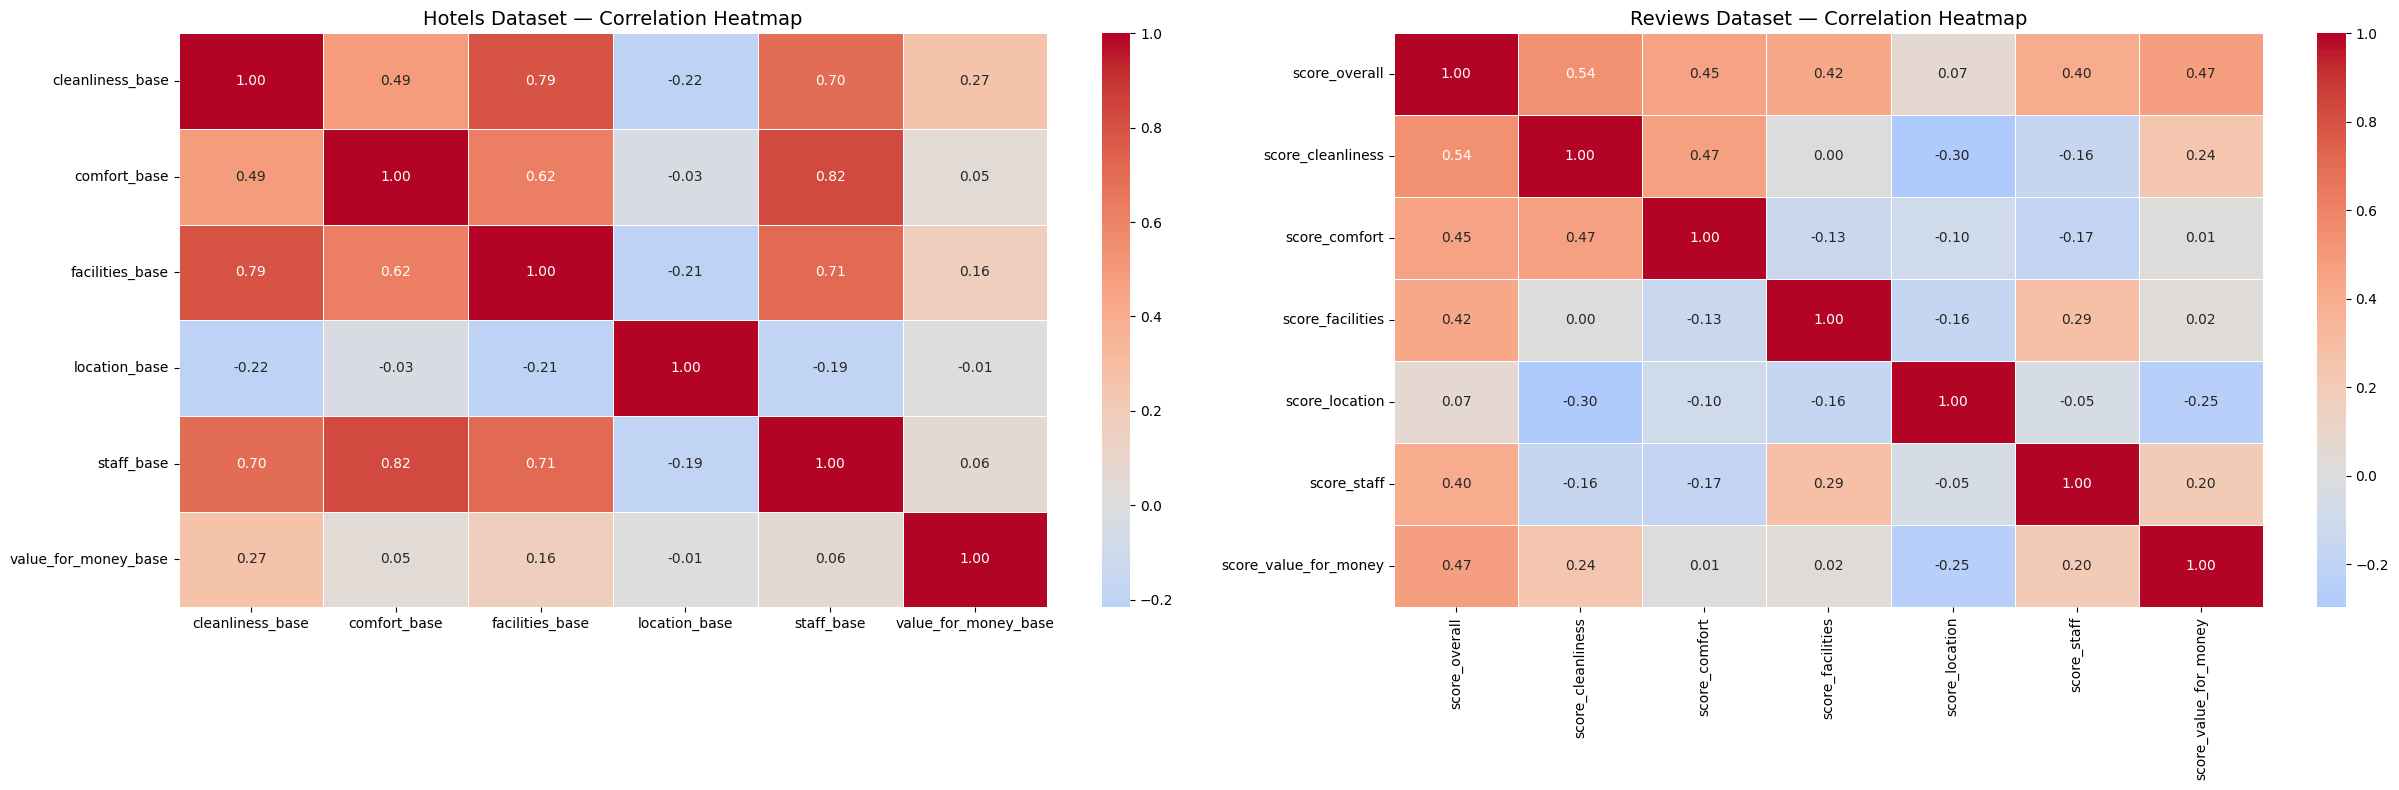

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_two_heatmaps(df1, cols1, name1, df2, cols2, name2):
    """Plot two correlation heatmaps side by side."""

    # Calculate correlations
    corr1 = df1[cols1].corr()
    corr2 = df2[cols2].corr()

    # Create side-by-side plots
    fig, axes = plt.subplots(1, 2, figsize=(25, 8))

    # Heatmap 1 — Hotels
    sns.heatmap(
        corr1, annot=True, cmap="coolwarm", center=0, fmt=".2f", linewidths=0.5,
        ax=axes[0]
    )
    axes[0].set_title(f"{name1} — Correlation Heatmap", fontsize=14)

    # Heatmap 2 — Reviews
    sns.heatmap(
        corr2, annot=True, cmap="coolwarm", center=0, fmt=".2f", linewidths=0.5,
        ax=axes[1]
    )
    axes[1].set_title(f"{name2} — Correlation Heatmap", fontsize=14)

    plt.tight_layout()
    plt.show()


# ==================== Run Side-by-Side Heatmaps ====================

plot_two_heatmaps(
    hotels,
    ['cleanliness_base', 'comfort_base', 'facilities_base', 'location_base', 'staff_base', 'value_for_money_base'],
    "Hotels Dataset",
    reviews,
    ['score_overall', 'score_cleanliness', 'score_comfort', 'score_facilities', 'score_location', 'score_staff', 'score_value_for_money'],
    "Reviews Dataset"
)


# Data Engineering Questions

This section answers specific analytical questions using the merged datasets.  
We will focus on deriving actionable insights, such as the best cities for different traveler types based on review scores.  

## Question 1

This question aims to identify, for each traveler type, the city with the highest average review score.  
We use the reviews dataset joined with user and hotel information to calculate these averages.

**Why it matters:**  
- Helps travel agencies, platforms, or recommendation systems suggest the most suitable city for each traveler type.  
- Provides insights on customer satisfaction patterns across different types of travelers.


### Which city is best for each traveler type?

This code computes the top city per traveler type based on review scores and visualizes the results.  

**How it works:**  
1. **Merge datasets:** Reviews are combined with users (traveller_type) and hotels (city) using their IDs.  
2. **Group by city and traveller type:** Average scores (`score_overall`) are calculated per city for each traveller type.  
3. **Select the top city:** For each traveller type, the city with the highest average score is selected.  
4. **Plotting:** A bar plot visualizes the average scores for the top city of each traveler type, including numerical annotations on the bars.  

**Expected output:**
- A table showing each traveler type and the top city for that type.  
- A bar chart with 4 bars, one per traveler type, showing the average review score of its top city.  
- The chart includes the numeric value of the average score above each bar for clarity.

**Visualization Description:**
- The bar plot displays the **best city per traveler type** using the average review score as a metric.  

- **Why it matters:**  
  - Makes it immediately clear which city is most preferred by each type of traveler.  
  - Enables quick comparison between traveler types.  

- **What to look for:**  
  - The height of each bar represents the average score of the top city.  
  - The numeric annotations above the bars provide exact average scores.  
  - Any patterns (e.g., certain traveler types consistently preferring high-scoring cities) can be observed at a glance.


,traveller_type,city,avg_score
0,Business,Dubai,8.965668
1,Couple,Amsterdam,9.096989
2,Family,Dubai,9.214381
3,Solo,Amsterdam,9.108454


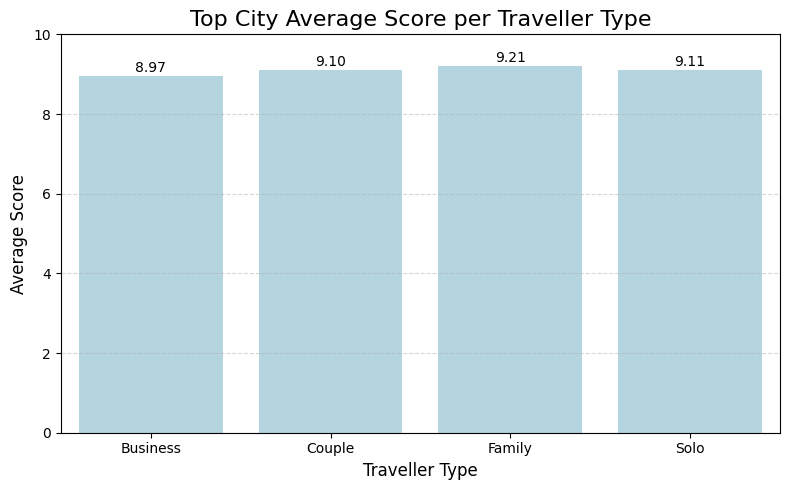

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# ================= Step 1: Merge datasets =================
merged_reviews = (
    reviews
    .merge(users[['user_id', 'traveller_type']], on='user_id', how='left')
    .merge(hotels[['hotel_id', 'city']], on='hotel_id', how='left')
)

# ================= Step 2: Group by city and traveller_type =================
city_traveller_avg = (
    merged_reviews
    .groupby(['traveller_type', 'city'], as_index=False)
    .agg({'score_overall': 'mean'})
    .rename(columns={'score_overall': 'avg_score'})
)

# ================= Step 3: Find the top city per traveller_type =================
best_city_per_type = (
    city_traveller_avg
    .sort_values(['traveller_type', 'avg_score'], ascending=[True, False])
    .groupby('traveller_type', as_index=False)
    .first()
)

# Display the top cities table
display(best_city_per_type)

# ================= Step 4: Plot the 4 numbers =================
plt.figure(figsize=(8, 5))
sns.barplot(
    data=best_city_per_type,
    x='traveller_type',
    y='avg_score',
    color='lightblue',   # set a single color instead of palette
)
plt.title("Top City Average Score per Traveller Type", fontsize=16)
plt.xlabel("Traveller Type", fontsize=12)
plt.ylabel("Average Score", fontsize=12)
plt.ylim(0, 10)  # assuming scores are out of 10

# annotate the numbers on top of bars
for i, v in enumerate(best_city_per_type['avg_score']):
    plt.text(i, v + 0.1, f"{v:.2f}", ha='center')

plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


## Question 2

This question aims to identify the top 3 countries with the highest average value-for-money scores for each traveler age group.  
We combine review, user, and hotel data to calculate these averages and visualize the results.

**Why it matters:**  
- Helps identify destinations that provide the best perceived value for money for different age groups.  
- Useful for travel planning, marketing strategies, or recommendation systems targeting specific age segments.


### Top 3 countries by value-for-money score per age group



This code computes the top 3 countries for each age group and visualizes them using a grouped bar plot.  

**How it works:**  
1. **Merge datasets:** Reviews are combined with users (age_group) and hotels (country) using their IDs.  
2. **Group by age group and country:** Calculate the average `score_value_for_money` per country for each age group.  
3. **Sort and pick top 3:** For each age group, select the three countries with the highest average value-for-money scores.  
4. **Plotting:** A grouped bar plot displays the top 3 countries per age group, with bars colored by country.  

**Expected output:**  
- A table showing the top 3 countries per age group along with their average value-for-money score.  
- A grouped bar chart where each group represents an age group, and each bar within the group represents one of the top 3 countries.  
- Bars are color-coded by country and labeled in the legend for easy comparison.


**Visualization Description:**  
- The grouped bar plot shows **top 3 countries for each age group** based on average value-for-money scores.  

- **Why it matters:**  
  - Makes it easy to compare countries across age groups.  
  - Highlights which countries provide the best perceived value for money to each age segment.  

- **What to look for:**  
  - Each cluster of bars represents an age group.  
  - Within each cluster, three bars correspond to the top 3 countries for that age group.  
  - The height of each bar shows the average value-for-money score (higher is better).  
  - The color-coded legend helps distinguish the countries at a glance.


- **Insights from the plot:**  
  From this visualization, you can quickly identify:  
  - Which age groups prefer which countries in terms of value for money.  
  - Patterns such as certain countries consistently performing well across multiple age groups.  
  - Potential target markets or marketing insights based on perceived value for specific demographics.



,age_group,country,avg_value_for_money
0,18-24,China,8.706926
1,18-24,Netherlands,8.704911
2,18-24,Canada,8.661261
3,25-34,China,8.727941
4,25-34,Netherlands,8.683442
5,25-34,Spain,8.625074
6,35-44,China,8.700799
7,35-44,Netherlands,8.693268
8,35-44,New Zealand,8.646429
9,45-54,China,8.722112


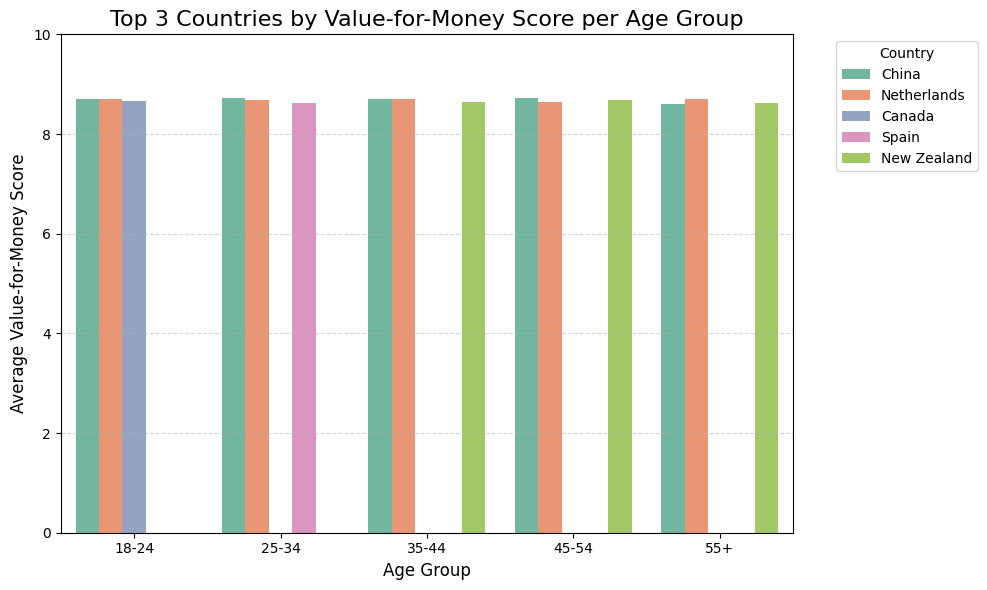

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# ================= Step 1: Merge datasets =================
merged_reviews_age = (
    reviews
    .merge(users[['user_id', 'age_group']], on='user_id', how='left')
    .merge(hotels[['hotel_id', 'country']], on='hotel_id', how='left')
)

# ================= Step 2: Group by age_group and country =================
country_age_avg = (
    merged_reviews_age
    .groupby(['age_group', 'country'], as_index=False)
    .agg({'score_value_for_money': 'mean'})
    .rename(columns={'score_value_for_money': 'avg_value_for_money'})
)

# ================= Step 3: Sort and pick top 3 per age_group =================
top3_countries_per_age = (
    country_age_avg
    .sort_values(['age_group', 'avg_value_for_money'], ascending=[True, False])
    .groupby('age_group')
    .head(3)
    .reset_index(drop=True)
)

# Display the table
display(top3_countries_per_age)

# ================= Step 4: Plotting =================
plt.figure(figsize=(10, 6))
sns.barplot(
    data=top3_countries_per_age,
    x='age_group',
    y='avg_value_for_money',
    hue='country',
    palette='Set2',
    dodge=True  # ensures bars are grouped tightly
)
plt.title("Top 3 Countries by Value-for-Money Score per Age Group", fontsize=16)
plt.xlabel("Age Group", fontsize=12)
plt.ylabel("Average Value-for-Money Score", fontsize=12)
plt.ylim(0, 10)
plt.legend(title="Country", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()



# Additional Features Added to the Dataset

## Hotel Base Scores



Each hotel has a set of base scores representing its fixed ratings across different metrics (such as cleanliness, comfort, facilities, location, staff, and value for money).
To summarize these values, two additional columns were created:

    overall_base → the average of all base scores for each hotel, providing a single measure of its general quality.

    overall_base_std → the standard deviation of the base scores, indicating how much the ratings vary across different aspects of the hotel

<br>

These engineered features will be utilized later as inputs to the predictive models.

In [ ]:

hotels['overall_base'] = hotels[['cleanliness_base', 'comfort_base', 'facilities_base',
                                 'location_base', 'staff_base', 'value_for_money_base']].mean(axis=1).round(1)

hotels['overall_base_std'] = hotels[['cleanliness_base', 'comfort_base', 'facilities_base',
                                     'location_base', 'staff_base', 'value_for_money_base']].std(axis=1).round(1)
hotels.head(25)


,hotel_id,hotel_name,city,country,star_rating,lat,lon,cleanliness_base,comfort_base,facilities_base,location_base,staff_base,value_for_money_base,country_group,overall_base,overall_base_std
0,1,The Azure Tower,New York,United States,5,40.75800,-73.985500,9.1,8.8,8.9,9.5,8.6,8.0,North_America,8.8,0.5
1,2,The Royal Compass,London,United Kingdom,5,51.50720,-0.127600,9.0,9.2,8.8,9.4,9.0,7.9,Western_Europe,8.9,0.5
2,3,L'Étoile Palace,Paris,France,5,48.85660,2.352200,8.8,9.4,8.7,9.6,9.3,8.1,Western_Europe,9.0,0.6
3,4,Kyo-to Grand,Tokyo,Japan,5,35.68950,139.691700,9.6,9.0,9.3,8.5,9.5,8.2,East_Asia,9.0,0.6
4,5,The Golden Oasis,Dubai,United Arab Emirates,5,25.27690,55.296200,9.3,9.5,9.6,8.9,9.4,8.5,Middle_East,9.2,0.4
5,6,Marina Bay Zenith,Singapore,Singapore,5,1.29027,103.851959,9.2,9.1,9.4,9.7,9.1,8.3,Southeast_Asia,9.1,0.5
6,7,Sydney Harbour Grand,Sydney,Australia,5,-33.86510,151.209900,8.9,9.0,8.5,9.8,8.9,8.4,Oceania,8.9,0.5
7,8,Copacabana Lux,Rio de Janeiro,Brazil,5,-22.90680,-43.172900,9.0,8.7,8.6,9.5,8.8,8.6,South_America,8.9,0.3
8,9,Berlin Mitte Elite,Berlin,Germany,5,52.52000,13.405000,9.3,9.2,9.0,9.1,9.1,8.7,Western_Europe,9.1,0.2
9,10,The Maple Grove,Toronto,Canada,5,43.65320,-79.383200,9.4,9.3,9.2,8.8,9.2,8.8,North_America,9.1,0.3


## Country Group Mapping

Each hotel in the dataset is associated with a specific country, which has been mapped to a broader country group (e.g., Western Europe, East Asia, North America, etc.).
This country group serves as the target variable for our classification model.

To ensure data consistency, a verification step was performed to confirm that every hotel has been correctly assigned to a country group, meaning no countries were left unmapped.

In [ ]:


# Define country group mapping
country_group_mapping = {
    "United States": "North_America",
    "Canada": "North_America",
    "Germany": "Western_Europe",
    "France": "Western_Europe",
    "United Kingdom": "Western_Europe",
    "Netherlands": "Western_Europe",
    "Spain": "Western_Europe",
    "Italy": "Western_Europe",
    "Russia": "Eastern_Europe",
    "China": "East_Asia",
    "Japan": "East_Asia",
    "South Korea": "East_Asia",
    "Thailand": "Southeast_Asia",
    "Singapore": "Southeast_Asia",
    "United Arab Emirates": "Middle_East",
    "Turkey": "Middle_East",
    "Egypt": "Africa",
    "Nigeria": "Africa",
    "South Africa": "Africa",
    "Australia": "Oceania",
    "New Zealand": "Oceania",
    "Brazil": "South_America",
    "Argentina": "South_America",
    "India": "South_Asia",
    "Mexico": "North_America_Mexico"
}

# Create new column using mapping
hotels["country_group"] = hotels["country"].map(country_group_mapping)

# Optional: check for unmapped countries
unmapped_countries = hotels[hotels["country_group"].isna()]["country"].unique()
if len(unmapped_countries) > 0:
    print("⚠️ Unmapped countries found:", unmapped_countries)
else:
    print("✅ All countries successfully mapped.")

hotels = hotels.drop(columns=[ "city", "country", "star_rating"])
users = users.drop(columns=[ "join_date"])
reviews = reviews.drop(columns=[ "review_date"])
# Display result
hotels.head()


✅ All countries successfully mapped.


,hotel_id,hotel_name,lat,lon,cleanliness_base,comfort_base,facilities_base,location_base,staff_base,value_for_money_base,country_group,overall_base,overall_base_std
0,1,The Azure Tower,40.7580,-73.9855,9.1,8.8,8.9,9.5,8.6,8.0,North_America,8.8,0.5
1,2,The Royal Compass,51.5072,-0.1276,9.0,9.2,8.8,9.4,9.0,7.9,Western_Europe,8.9,0.5
2,3,L'Étoile Palace,48.8566,2.3522,8.8,9.4,8.7,9.6,9.3,8.1,Western_Europe,9.0,0.6
3,4,Kyo-to Grand,35.6895,139.6917,9.6,9.0,9.3,8.5,9.5,8.2,East_Asia,9.0,0.6
4,5,The Golden Oasis,25.2769,55.2962,9.3,9.5,9.6,8.9,9.4,8.5,Middle_East,9.2,0.4


In [ ]:
users.head()

,user_id,user_gender,country,age_group,traveller_type
0,1,Female,United Kingdom,35-44,Solo
1,2,Male,United Kingdom,25-34,Solo
2,3,Female,Mexico,25-34,Family
3,4,Male,India,35-44,Family
4,5,Other,Japan,25-34,Solo


Review text in our context is not of use so it is dropped

In [ ]:
reviews=reviews.drop(columns=["review_text"])
reviews.head()

,review_id,user_id,hotel_id,score_overall,score_cleanliness,score_comfort,score_facilities,score_location,score_staff,score_value_for_money
0,1,1600,1,8.7,8.6,8.7,8.5,9.0,8.8,8.7
1,2,432,4,9.1,10.0,9.1,9.0,8.6,9.4,8.6
2,3,186,18,8.8,9.7,8.8,8.3,8.7,8.1,8.6
3,4,1403,19,8.9,9.0,8.8,8.5,9.6,9.1,8.3
4,5,1723,17,9.1,8.9,9.5,9.3,8.3,9.4,8.9


# DataSets Merging



The three datasets — Hotels, Users, and Reviews — are merged using their respective identifiers:

    hotel_id → links hotel details

    user_id → links reviewer information

    review_id → links specific review entries

This merging step ensures that each user is correctly mapped to their corresponding review and the hotel they reviewed.

The resulting merged dataframe serves as the core dataset for the project, from which the relevant input features will be selected during model creation.

In [ ]:
merged_df = reviews.merge(hotels, on="hotel_id", how="left")
merged_df = merged_df.merge(users, on="user_id", how="left")
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

print("Merged dataset shape:", merged_df.shape)
merged_df.head()

Merged dataset shape: (50000, 26)


,review_id,user_id,hotel_id,score_overall,score_cleanliness,score_comfort,score_facilities,score_location,score_staff,score_value_for_money,hotel_name,lat,lon,cleanliness_base,comfort_base,facilities_base,location_base,staff_base,value_for_money_base,country_group,overall_base,overall_base_std,user_gender,country,age_group,traveller_type
0,1,1600,1,8.7,8.6,8.7,8.5,9.0,8.8,8.7,The Azure Tower,40.7580,-73.9855,9.1,8.8,8.9,9.5,8.6,8.0,North_America,8.8,0.5,Female,New Zealand,25-34,Solo
1,2,432,4,9.1,10.0,9.1,9.0,8.6,9.4,8.6,Kyo-to Grand,35.6895,139.6917,9.6,9.0,9.3,8.5,9.5,8.2,East_Asia,9.0,0.6,Female,United Kingdom,35-44,Couple
2,3,186,18,8.8,9.7,8.8,8.3,8.7,8.1,8.6,Nile Grandeur,30.0444,31.2357,8.8,8.7,8.6,9.1,8.7,8.4,Africa,8.7,0.2,Female,Spain,55+,Couple
3,4,1403,19,8.9,9.0,8.8,8.5,9.6,9.1,8.3,Gaudi's Retreat,41.3851,2.1734,9.2,9.1,8.9,9.7,9.0,8.8,Western_Europe,9.1,0.3,Female,United Kingdom,35-44,Business
4,5,1723,17,9.1,8.9,9.5,9.3,8.3,9.4,8.9,Kremlin Suites,55.7558,37.6173,9.1,9.3,9.0,9.0,9.1,8.6,Eastern_Europe,9.0,0.2,Male,Australia,45-54,Family


# Feature Engineering: Difference and Consistency Metrics

To reduce data leakage and prevent the model from memorizing hotel-specific information, several difference-based features are created:

    overall_diff → Represents the difference between the user’s overall rating (score_overall) and the hotel’s average base score (overall_base).
This acts as a neutralized indicator of how much higher or lower a user rated the hotel compared to its typical average.

    Per-metric difference columns → For each rating category (e.g., cleanliness, comfort, facilities, etc.), a new column is created showing how the user’s rating differs from the hotel’s base rating.

Example:

**score_cleanliness_diff = score_cleanliness − cleanliness_base**

    user_std → The standard deviation of all rating metrics given by a user.
This feature captures the user’s rating consistency — a lower standard deviation indicates more uniform ratings, while a higher one suggests variability in how they evaluate different aspects.

    user_std_diff → The difference between the user’s standard deviation and the hotel’s base standard deviation (overall_base_std).
This reflects how consistent the user’s ratings are relative to the hotel’s own score variability.

These engineered features help the model understand relative behavior between users and hotels without directly exposing it to fixed hotel attributes.

In [ ]:
merged_df["overall_diff"] = merged_df["score_overall"] - merged_df["overall_base"]
for col in ["cleanliness", "comfort", "facilities", "location", "staff", "value_for_money"]:
    merged_df[f"score_{col}_diff"] = merged_df[f"score_{col}"] - merged_df[f"{col}_base"]

merged_df['user_std'] = merged_df[['score_cleanliness', 'score_comfort', 'score_facilities',
                                     'score_location', 'score_staff', 'score_value_for_money']].std(axis=1).round(1)
merged_df['user_std_diff'] = merged_df['user_std'] - merged_df['overall_base_std']


Some columns like ids and names will not be needed at all so they are dropped

In [ ]:
merged_df=merged_df.drop(columns=["review_id", "user_id" , "hotel_id", "hotel_name", "lat", "lon"])

In [ ]:
merged_df.head()

,score_overall,score_cleanliness,score_comfort,score_facilities,score_location,score_staff,score_value_for_money,cleanliness_base,comfort_base,facilities_base,location_base,staff_base,value_for_money_base,country_group,overall_base,overall_base_std,user_gender,country,age_group,traveller_type,overall_diff,score_cleanliness_diff,score_comfort_diff,score_facilities_diff,score_location_diff,score_staff_diff,score_value_for_money_diff,user_std,user_std_diff
0,8.7,8.6,8.7,8.5,9.0,8.8,8.7,9.1,8.8,8.9,9.5,8.6,8.0,North_America,8.8,0.5,Female,New Zealand,25-34,Solo,-0.1,-0.5,-0.1,-0.4,-0.5,0.2,0.7,0.2,-0.3
1,9.1,10.0,9.1,9.0,8.6,9.4,8.6,9.6,9.0,9.3,8.5,9.5,8.2,East_Asia,9.0,0.6,Female,United Kingdom,35-44,Couple,0.1,0.4,0.1,-0.3,0.1,-0.1,0.4,0.5,-0.1
2,8.8,9.7,8.8,8.3,8.7,8.1,8.6,8.8,8.7,8.6,9.1,8.7,8.4,Africa,8.7,0.2,Female,Spain,55+,Couple,0.1,0.9,0.1,-0.3,-0.4,-0.6,0.2,0.6,0.4
3,8.9,9.0,8.8,8.5,9.6,9.1,8.3,9.2,9.1,8.9,9.7,9.0,8.8,Western_Europe,9.1,0.3,Female,United Kingdom,35-44,Business,-0.2,-0.2,-0.3,-0.4,-0.1,0.1,-0.5,0.5,0.2
4,9.1,8.9,9.5,9.3,8.3,9.4,8.9,9.1,9.3,9.0,9.0,9.1,8.6,Eastern_Europe,9.0,0.2,Male,Australia,45-54,Family,0.1,-0.2,0.2,0.3,-0.7,0.3,0.3,0.4,0.2


In [ ]:
unique_values = merged_df['overall_base'].unique()
print(unique_values)

[8.8 9.  8.7 9.1 8.9 8.6 9.2]


In [ ]:
# from google.colab import files

# # Save your DataFrame to a CSV file
# merged_df.to_csv('my_cleaned_dataset.csv', index=False)

# # Download the file to your local device
# files.download('my_cleaned_dataset.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# model without anything related to the bases of the hotels (Main)

The model trained with the features score_cleanliness, score_comfort, score_facilities, score_location, score_staff, score_value_for_money, age_group, and traveller_type represents the version without any data leakage, as it only incorporates user and review data. This model achieves approximately 40% accuracy, reflecting the absence of a direct mapping to hotel or country information. The SHAP analysis reveals that traveller_type is the most influential feature, followed by the individual user scores and subsequently the age_group.

✅ Features encoded and target prepared.
Feature matrix shape: (50000, 13)
Target classes: ['Africa' 'East_Asia' 'Eastern_Europe' 'Middle_East' 'North_America'
 'North_America_Mexico' 'Oceania' 'South_America' 'South_Asia'
 'Southeast_Asia' 'Western_Europe']
✅ Data split and scaled.
Train shape: (35000, 13), Val shape: (7500, 13), Test shape: (7500, 13)
Epoch 1/100
547/547 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - accuracy: 0.2803 - loss: 2.1124 - val_accuracy: 0.3572 - val_loss: 1.8674 - learning_rate: 0.0010
Epoch 2/100
547/547 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3405 - loss: 1.9101 - val_accuracy: 0.3705 - val_loss: 1.8111 - learning_rate: 0.0010
Epoch 3/100
547/547 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.3534 - loss: 1.8570 - val_accuracy: 0.3705 - val_loss: 1.7965 - learning_rate: 0.0010
Epoch 4/100
547/547 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.3629 - loss: 1.8264 - val_accuracy: 0.3748 - val_loss: 1.7616 - learning_rate: 0.0010
Epoch 5/100
547/547 ━━━━━━━━━━━

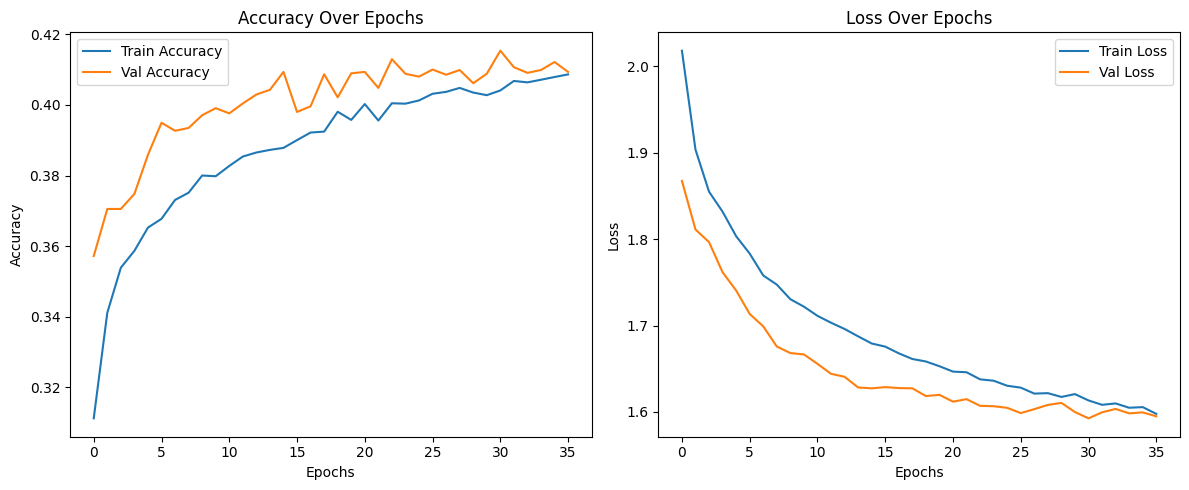

235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

 Overall Evaluation Metrics:
Accuracy:          0.3953
Macro Precision:   0.4792
Macro Recall:      0.2582
Macro F1 Score:    0.2616
Weighted Precision:0.4442
Weighted Recall:   0.3953
Weighted F1 Score: 0.3434

 Confusion Matrix:
[[ 481   13    2    1    9    0   13   26    0    3  372]
 [  19  412    8   34   21    0    5    8    0   39  366]
 [  21   48   19   13    9    1    2    3    0   10  170]
 [  52  117    2  139   19    0    5   31    0   15  217]
 [  64   99    8   14  130    0    9   13    0   12  245]
 [ 216    3    2    0    1    1   11   12    0    0   55]
 [  59   68   12    4   24    0   95   22    0    8  310]
 [ 239   15    3    1   13    0   30   96    0    1  189]
 [ 127    5    5    2    8    0    8   44    3    1   95]
 [  30   40    2   19    7    0    3    6    0  115  389]
 [  86   78   10    5   38    0   36   22    0   33 1474]]


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow import keras
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# ====================== CONFIGURATION ======================
use_categorical = True

features = ['score_cleanliness', 'score_comfort',
            'score_facilities', 'score_location', 'score_staff',
            'score_value_for_money', 'age_group', 'traveller_type']

target_col = "country_group"

# ====================== FEATURE ENCODING ======================
X = merged_df[features].copy()
y = merged_df[target_col]

categorical_cols = ['age_group', 'traveller_type'] if use_categorical else []
numeric_cols = [col for col in X.columns if col not in categorical_cols]

# One-hot encode if categorical vars are included
if use_categorical and categorical_cols:
    ct = ColumnTransformer(
        transformers=[
            ('onehot', OneHotEncoder(drop='first', sparse_output=False), categorical_cols)
        ],
        remainder='passthrough'
    )
    X_encoded = ct.fit_transform(X)
    ohe_feature_names = ct.named_transformers_['onehot'].get_feature_names_out(categorical_cols)
    all_feature_names = list(ohe_feature_names) + numeric_cols
else:
    X_encoded = X.values
    all_feature_names = X.columns.tolist()

X_encoded_df = pd.DataFrame(X_encoded, columns=all_feature_names)

# Encode target
target_le = LabelEncoder()
y = target_le.fit_transform(y)

print("✅ Features encoded and target prepared.")
print("Feature matrix shape:", X_encoded_df.shape)
print("Target classes:", target_le.classes_)

# ====================== TRAIN-VALIDATION-TEST SPLIT & SCALING ======================
# First split into train (70%) and temp (30%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X_encoded, y, test_size=0.3, random_state=69, stratify=y
)

# Then split temp equally into validation (15%) and test (15%)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=69, stratify=y_temp
)

# Scale using training data only
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print("✅ Data split and scaled.")
print(f"Train shape: {X_train_scaled.shape}, Val shape: {X_val_scaled.shape}, Test shape: {X_test_scaled.shape}")

# ====================== MODEL DEFINITION ======================
input_dim = X_train_scaled.shape[1]
num_classes = len(target_le.classes_)

model_40 = models.Sequential([
    layers.Input(shape=(input_dim,)),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(num_classes, activation='softmax')

])

model_40.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# ====================== CALLBACKS ======================
early_stop = EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True
)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5, verbose=1
)

# ====================== TRAINING ======================
history = model_40.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=100,
    batch_size=64,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

print("\n✅ Training completed.")
print(f"Best validation accuracy: {max(history.history['val_accuracy']):.4f}")

# ====================== PLOTTING ======================
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

# ====================== EVALUATION ======================
y_pred = np.argmax(model_40.predict(X_test_scaled), axis=1)
acc = accuracy_score(y_test, y_pred)

# Macro and weighted averages
precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(y_test, y_pred, average='macro')
precision_weighted, recall_weighted, f1_weighted, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')

print("\n Overall Evaluation Metrics:")
print(f"Accuracy:          {acc:.4f}")
print(f"Macro Precision:   {precision_macro:.4f}")
print(f"Macro Recall:      {recall_macro:.4f}")
print(f"Macro F1 Score:    {f1_macro:.4f}")
print(f"Weighted Precision:{precision_weighted:.4f}")
print(f"Weighted Recall:   {recall_weighted:.4f}")
print(f"Weighted F1 Score: {f1_weighted:.4f}")

print("\n Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


In [ ]:
from sklearn.metrics import classification_report

# Decode labels back to class names for readability
y_test_labels = target_le.inverse_transform(y_test)
y_pred_labels = target_le.inverse_transform(y_pred)

# Classification report per class
report = classification_report(
    y_test_labels,
    y_pred_labels,
    target_names=target_le.classes_,
    output_dict=True
)

# Convert to DataFrame for better display
report_df = pd.DataFrame(report).transpose()

# Display the table
print("\n📊 Detailed Classification Report per Target Class:\n")
display(report_df.round(4))



📊 Detailed Classification Report per Target Class:



,precision,recall,f1-score,support
Africa,0.3451,0.5228,0.4157,920.0000
East_Asia,0.4588,0.4518,0.4552,912.0000
Eastern_Europe,0.2603,0.0642,0.1030,296.0000
Middle_East,0.5991,0.2328,0.3353,597.0000
North_America,0.4659,0.2189,0.2978,594.0000
North_America_Mexico,0.5000,0.0033,0.0066,301.0000
Oceania,0.4378,0.1578,0.2320,602.0000
South_America,0.3392,0.1635,0.2207,587.0000
South_Asia,1.0000,0.0101,0.0199,298.0000
Southeast_Asia,0.4852,0.1882,0.2712,611.0000


Model output check:
Predicted probabilities shape: (3, 11)
Predicted probabilities example:
 [[2.2860409e-03 4.1851643e-01 2.6330866e-02 1.2417234e-01 1.3770613e-01
  1.1801211e-06 1.0917071e-01 4.9239548e-04 2.3039144e-04 2.6453739e-02
  1.5463974e-01]
 [3.5030686e-03 1.4384525e-03 1.0870426e-06 4.0327682e-06 2.3279072e-06
  1.5656028e-17 3.0659208e-02 6.4813844e-07 3.5160032e-12 2.6272565e-01
  7.0166552e-01]
 [5.2175965e-02 1.3957325e-01 1.4936666e-01 6.9984607e-02 6.8336509e-02
  1.1766998e-02 9.6892282e-02 7.4245809e-03 3.9325245e-03 1.3011850e-01
  2.7042812e-01]]

LabelEncoder classes (order): ['Africa', 'East_Asia', 'Eastern_Europe', 'Middle_East', 'North_America', 'North_America_Mexico', 'Oceania', 'South_America', 'South_Asia', 'Southeast_Asia', 'Western_Europe']

Decoded predictions (sanity check): ['East_Asia' 'Western_Europe' 'Western_Europe']

============= LIME ===============

Predicted probabilities:
Africa: 0.05
East_Asia: 0.04
Eastern_Europe: 0.00
Middle_East: 0.05
N


Feature contributions (LIME weights):
score_comfort <= -0.77: -0.269
traveller_type_Family <= -0.56: -0.228
traveller_type_Solo > -0.51: 0.180
score_staff > 0.58: 0.174
score_location > 0.77: 0.101
0.12 < score_value_for_money <= 0.69: -0.084
age_group_45-54 <= -0.43: 0.022
traveller_type_Couple <= -0.73: 0.021
age_group_55+ <= -0.33: -0.014
-0.08 < score_facilities <= 0.72: 0.014

============= SHAP ===============


/usr/local/lib/python3.12/dist-packages/shap/explainers/_deep/deep_tf.py:94: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_108
Received: inputs=['Tensor(shape=(100, 13))']
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_108
Received: inputs=['Tensor(shape=(200, 13))']
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_108
Received: inputs=['Tensor(shape=(10, 13))']
  warni

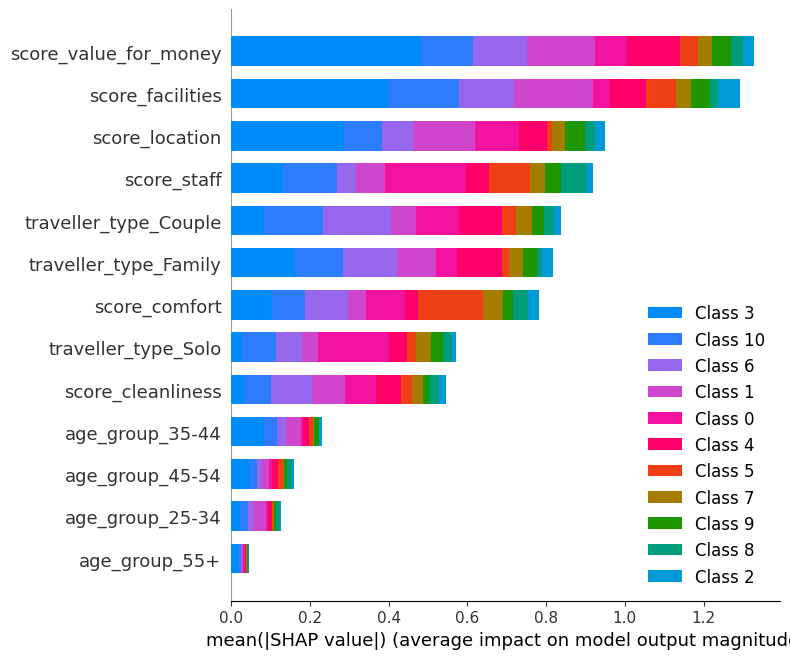

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


In [ ]:
# =========================================
# ✅ Imports
# =========================================
import numpy as np
import pandas as pd
import lime
import lime.lime_tabular
import shap
import matplotlib.pyplot as plt

# =========================================
# ✅ Verify model and data
# =========================================
# Assumptions:
#   - model: trained Keras/TensorFlow model
#   - X_train_scaled, X_test_scaled: scaled feature sets
#   - target_le: fitted LabelEncoder (for target)
#   - all_feature_names: list of feature names

print("Model output check:")
sample_pred = model_40.predict(X_test_scaled[:3], verbose=0)
print("Predicted probabilities shape:", sample_pred.shape)
print("Predicted probabilities example:\n", sample_pred)

print("\nLabelEncoder classes (order):", list(target_le.classes_))

# =========================================
# ✅ STEP 1 — Match class order correctly
# =========================================
pred_indices = np.argmax(sample_pred, axis=1)
decoded_preds = target_le.inverse_transform(pred_indices)
print("\nDecoded predictions (sanity check):", decoded_preds)

# Verified class order
class_names_ordered = list(target_le.classes_)

# =========================================
# ✅ STEP 2 — LIME Explanation (Local)
# =========================================
print("\n============= LIME ===============")

lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train_scaled,
    feature_names=all_feature_names,
    class_names=class_names_ordered,
    mode='classification'
)

i = 18  # choose a test instance to explain
sample = X_test_scaled[i]

# Predict probabilities for this sample
pred = model_40.predict(np.array([sample]), verbose=0)[0]
pred_class_idx = np.argmax(pred)
pred_class_name = class_names_ordered[pred_class_idx]

print("\nPredicted probabilities:")
for name, p in zip(class_names_ordered, pred):
    print(f"{name}: {p:.2f}")
print(f"\n🟩 Predicted Class: {pred_class_name}")

# Explain instance only for the predicted class
lime_exp = lime_explainer.explain_instance(
    data_row=sample,
    predict_fn=lambda x: model_40.predict(x, verbose=0),
    labels=[pred_class_idx],
    num_features=10
)

lime_exp.show_in_notebook(show_table=True, show_all=False, labels=[pred_class_idx])

print("\nFeature contributions (LIME weights):")
for feature, weight in lime_exp.as_list(label=pred_class_idx):
    print(f"{feature}: {weight:.3f}")

# =========================================
# ✅ STEP 3 — SHAP Explanation (Local + Global)
# =========================================
print("\n============= SHAP ===============")
import shap
import numpy as np

shap.initjs()  # enable interactive JS visualizations

background = shap.sample(X_train_scaled, 100, random_state=42)

explainer = shap.DeepExplainer(model_40, background)

X_sample = X_test_scaled[:10]  # explain first 10 samples

shap_values = explainer.shap_values(X_sample)

shap.summary_plot(shap_values, X_sample, feature_names=all_feature_names, plot_type='bar')

preds = model_40.predict(X_sample)
if not isinstance(preds, np.ndarray):
    preds = preds.numpy()  # convert if EagerTensor

sample_idx = 0
predicted_class = np.argmax(preds[sample_idx])

shap_values_class = shap_values[sample_idx, :, predicted_class]

shap_values_class = np.array(shap_values_class)
X_sample_np = np.array(X_sample[sample_idx])

shap.force_plot(
    float(explainer.expected_value[predicted_class]),
    shap_values_class,
    X_sample_np,
    feature_names=all_feature_names
)

# Inference Function

In [ ]:
# ====================== INTERACTIVE INFERENCE FUNCTION ======================

def infer_country_group_interactive(model):
    """
    Interactively asks the user for all inputs, validates them, applies the same
    preprocessing pipeline, and prints the predicted country group and confidence.
    """

    print("🌍 Let's predict the country group based on your travel review scores!\n")

    # Define allowed categories
    allowed_age_groups = ['18-24', '25-34', '35-44', '45-54', '55+']
    allowed_traveller_types = ['Solo', 'Family', 'Couple', 'Business']

    # Collect numeric scores
    numeric_inputs = {}
    numeric_fields = [
        'score_cleanliness', 'score_comfort', 'score_facilities',
        'score_location', 'score_staff', 'score_value_for_money'
    ]

    for field in numeric_fields:
        while True:
            try:
                value = float(input(f"Enter {field.replace('_', ' ')} (0–10): "))
                if 0 <= value <= 10:
                    numeric_inputs[field] = value
                    break
                else:
                    print("❌ Please enter a value between 0 and 10.")
            except ValueError:
                print("❌ Invalid input. Please enter a number between 0 and 10.")

    # Select age_group
    print("\nSelect your age group:")
    for i, ag in enumerate(allowed_age_groups, 1):
        print(f"  {i}. {ag}")
    while True:
        choice = input("Enter the number corresponding to your age group: ")
        if choice.isdigit() and 1 <= int(choice) <= len(allowed_age_groups):
            age_group = allowed_age_groups[int(choice) - 1]
            break
        else:
            print("❌ Invalid choice. Try again.")

    # Select traveller_type
    print("\nSelect your traveller type:")
    for i, tt in enumerate(allowed_traveller_types, 1):
        print(f"  {i}. {tt}")
    while True:
        choice = input("Enter the number corresponding to your traveller type: ")
        if choice.isdigit() and 1 <= int(choice) <= len(allowed_traveller_types):
            traveller_type = allowed_traveller_types[int(choice) - 1]
            break
        else:
            print("❌ Invalid choice. Try again.")

    # Combine into one input dictionary
    raw_input = {**numeric_inputs,
                 'age_group': age_group,
                 'traveller_type': traveller_type}

    print("\n✅ Input summary:")
    for k, v in raw_input.items():
        print(f"  {k}: {v}")

    # --- Apply same preprocessing ---
    input_df = pd.DataFrame([raw_input])

    if use_categorical and categorical_cols:
        X_encoded = ct.transform(input_df)
        ohe_feature_names = ct.named_transformers_['onehot'].get_feature_names_out(categorical_cols)
        all_feature_names = list(ohe_feature_names) + numeric_cols
        encoded_df = pd.DataFrame(X_encoded, columns=all_feature_names)
    else:
        encoded_df = input_df.copy()

    X_scaled = scaler.transform(encoded_df)

    # --- Prediction ---
    preds = model.predict(X_scaled)
    predicted_class_index = np.argmax(preds, axis=1)[0]
    predicted_label = target_le.inverse_transform([predicted_class_index])[0]

    # --- Conversational-style output with prediction value ---
    print("\n💬 AI Assistant:")
    print(f"   After analyzing your review, I predict your country group is **{predicted_label}** ")


    # Return structured result as well
    return predicted_label

In [ ]:
infer_country_group_interactive(model_40)

🌍 Let's predict the country group based on your travel review scores!

Enter score cleanliness (0–10): 9
Enter score comfort (0–10): 11
❌ Please enter a value between 0 and 10.
Enter score comfort (0–10): 8.9
Enter score facilities (0–10): 7.9
Enter score location (0–10): 8.3
Enter score staff (0–10): 8.5
Enter score value for money (0–10): 8.7

Select your age group:
  1. 18-24
  2. 25-34
  3. 35-44
  4. 45-54
  5. 55+
Enter the number corresponding to your age group: 5

Select your traveller type:
  1. Solo
  2. Family
  3. Couple
  4. Business
Enter the number corresponding to your traveller type: 2

✅ Input summary:
  score_cleanliness: 9.0
  score_comfort: 8.9
  score_facilities: 7.9
  score_location: 8.3
  score_staff: 8.5
  score_value_for_money: 8.7
  age_group: 55+
  traveller_type: Family
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step

💬 AI Assistant:
   After analyzing your review, I predict your country group is **Africa** 


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


'Africa'

In [ ]:
infer_country_group_interactive(model_40)

🌍 Let's predict the country group based on your travel review scores!

Enter score cleanliness (0–10): 10
Enter score comfort (0–10): 9
Enter score facilities (0–10): 8.9
Enter score location (0–10): 6.9
Enter score staff (0–10): 86
❌ Please enter a value between 0 and 10.
Enter score staff (0–10): 8.5
Enter score value for money (0–10): 5.5

Select your age group:
  1. 18-24
  2. 25-34
  3. 35-44
  4. 45-54
  5. 55+
Enter the number corresponding to your age group: 2

Select your traveller type:
  1. Solo
  2. Family
  3. Couple
  4. Business
Enter the number corresponding to your traveller type: 1

✅ Input summary:
  score_cleanliness: 10.0
  score_comfort: 9.0
  score_facilities: 8.9
  score_location: 6.9
  score_staff: 8.5
  score_value_for_money: 5.5
  age_group: 25-34
  traveller_type: Solo
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step

💬 AI Assistant:
   After analyzing your review, I predict your country group is **East_Asia** 


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


'East_Asia'